In [67]:
%matplotlib inline
from fgspectra import cross as fgc
from fgspectra import power as fgp
from fgspectra import frequency as fgf
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sensitivity_calculator as sens
from scipy.optimize import minimize
import sys
sys.path.append('/root/')
import pcl_actpol_utility_v4 as pau
import emcee
import corner
import tqdm

def get_hivon_fsky(mask):
    npix = len(mask)
    non0 = np.where(mask!=0)[0]
    fs = len(non0)/float(npix)
    w2 = np.sum(mask[non0]**2)/(npix*fs)
    w4 = np.sum(mask[non0]**4)/(npix*fs)
    return fs*w2**2/w4


#range for power spectra
ells = np.arange(2, 8000)

#parameters for fgspectra
par = {
    "nu_0": 150.0,
    "ell_0": 3000,
    "T_CMB": 2.725,
    "T_d": 9.7,
    "a_tSZ": 4.66,
    "a_kSZ": 1.60,
    "a_p": 6.87,
    "beta_p": 2.08,
    "a_c": 6.10,
    "beta_c": 2.08,
    "n_CIBC": 1.20,
    "xi": 0.09,
    "a_s": 3.50,
    "a_g": 0.88,
}
# define the models from fgspectra
ksz = fgc.FactorizedCrossSpectrum(fgf.ConstantSED(), fgp.kSZ_bat())
cibp = fgc.FactorizedCrossSpectrum(fgf.ModifiedBlackBody(), fgp.PowerLaw())
radio = fgc.FactorizedCrossSpectrum(fgf.PowerLaw(), fgp.PowerLaw())
cirrus = fgc.FactorizedCrossSpectrum(fgf.PowerLaw(), fgp.PowerLaw())

# if there are correlations between components,
# have to define them in a joined spectrum
tSZ_and_CIB = fgc.CorrelatedFactorizedCrossSpectrum(
    fgf.Join(fgf.ThermalSZ(), fgf.CIB()), fgp.SZxCIB_Addison2012()
)

# for testing purposes we'll also compute the tSZ and clustered CIB alone
tsz = fgc.FactorizedCrossSpectrum(fgf.ThermalSZ(), fgp.tSZ_150_bat())
cibc = fgc.FactorizedCrossSpectrum(fgf.CIB(), fgp.PowerLaw())
def get_fg_model(freqs, ells, par):
    return (
        par["a_kSZ"] * ksz({"nu": freqs}, {"ell": ells, "ell_0": par["ell_0"]}),
        par["a_p"]
        * cibp(
            {
                "nu": freqs,
                "nu_0": par["nu_0"],
                "temp": par["T_d"],
                "beta": par["beta_p"],
            },
            {"ell": ells, "ell_0": par["ell_0"], "alpha": 2},
        ),
        # joint tSZ, CIB, and their correlation
        tSZ_and_CIB(
            {
                "kwseq": (
                    {"nu": freqs, "nu_0": par["nu_0"]},
                    {
                        "nu": freqs,
                        "nu_0": par["nu_0"],
                        "temp": par["T_d"],
                        "beta": par["beta_c"],
                    },
                )
            },
            {
                "kwseq": (
                    {"ell": ells, "ell_0": par["ell_0"], "amp": par["a_tSZ"]},
                    {
                        "ell": ells,
                        "ell_0": par["ell_0"],
                        "alpha": 2 - par["n_CIBC"],
                        "amp": par["a_c"],
                    },
                    {
                        "ell": ells,
                        "ell_0": par["ell_0"],
                        "amp": -par["xi"] * np.sqrt(par["a_tSZ"] * par["a_c"]),
                    },
                )
            },
        ),
        par["a_s"]
        * radio(
            {"nu": freqs, "nu_0": par["nu_0"], "beta": -0.5 - 2},
            {"ell": ells, "ell_0": par["ell_0"], "alpha": 2},
        ),
        par["a_g"]
        * cirrus(
            {"nu": freqs, "nu_0": par["nu_0"], "beta": 3.8 - 2},
            {"ell": ells, "ell_0": par["ell_0"], "alpha": -0.7},
        ),
        # THESE TWO ARE REDUDUNDANT, BUT USEFUL FOR TESTING
        par["a_tSZ"]
        * tsz({"nu": freqs, "nu_0": par["nu_0"]}, {"ell": ells, "ell_0": par["ell_0"]}),
        par["a_c"]
        * cibc(
            {
                "nu": freqs,
                "nu_0": par["nu_0"],
                "temp": par["T_d"],
                "beta": par["beta_c"],
            },
            {"ell": ells, "ell_0": par["ell_0"], "alpha": 2 - par["n_CIBC"]},
        ),
    )

#(env)$ python3 -m ipykernel install --user --name=env


###############################################################################################333
#use sensitivity calculator 
inputs = {'diameter': 5.7, 't': 273, 'wfe': 10.7, 'eta': 0.98, 'doe': 0.8, 't_int': 1, 'pixelYield': 0.8, 
        'szCamNumPoln': 1, 'eorSpecNumPoln': 2, 't_filter_cold': np.array([0.593, 0.84 , 0.86, 0.86, 0.89 ]), 
        't_lens_cold': np.array([0.98, 0.98, 0.98, 0.98, 0.98]), 
        't_uhdpe_window': np.array([0.96, 0.97, 0.97, 0.97, 0.97]), 
        'singleModedAOmegaLambda2': np.array([1., 1., 1., 1., 1.]), 
        'spatialPixels': np.array([39762, 20808, 10368, 10368,  7938]), 
        'eqbw': np.array([9.7e+10, 3.0e+10, 3.5e+10, 6.0e+10, 5.6e+10]), 
        'centerFrequency': np.array([8.50e+11, 4.05e+11, 3.48e+11, 2.80e+11, 2.22e+11]), 'detectorNEP': 0, 
        'backgroundSubtractionDegradationFactor': 1, 'r': np.array([[100., 100., 100.],
                                            [100., 100., 100.],
                                            [100., 100., 100.],
                                            [100., 100., 100.],
                                            [100., 100., 100.]]), 
        'decimalPlaces': 3, 'observationElevationAngle': 45, 'outputFreq': True, 
        'detectorSpacing': np.array([1.45, 1.97, 2.75, 2.75, 3.13]), 'lyotStopAngle': 13.4}
# Alternatively, sens.getInputs("input.yaml")

#spillEfficiency = sens.getSpillEfficiency(inputs, oldFile=False)
#print(spillEfficiency)
spillEfficiency = sens.getSpillEfficiency(inputs, oldFile=True)
#print(spillEfficiency)
# spillEfficienc#y = np.array([0.8,0.5,0.7,0.95,0.5])
calculate = sens.calcByAngle(inputs["diameter"], inputs["t"], inputs["wfe"], inputs["eta"], inputs["doe"], inputs["t_int"], inputs["pixelYield"], inputs["szCamNumPoln"], inputs["eorSpecNumPoln"],
                            inputs["t_filter_cold"], inputs["t_lens_cold"], inputs["t_uhdpe_window"], spillEfficiency, inputs["singleModedAOmegaLambda2"],
                            inputs["spatialPixels"], inputs["eqbw"], inputs["centerFrequency"], inputs["detectorNEP"],
                            inputs["backgroundSubtractionDegradationFactor"], inputs["r"])
outputs = calculate(45) #45 degree angle

#get noise from sens, by l, temp noise, and pol noise
ell, N_ell_T_full, N_ell_P_full = sens.getNoiseCurves(inputs, outputs)
dl = ell*(ell+1)/(2*np.pi)

#get sky fraction fsky
NSIDE = 1024
hitmap_path = "~/mask_share/ccat_uniform_coverage_nside" + str(NSIDE) + "_201021.fits"
mask_path = "~/mask_share/nside" + str(NSIDE) + "_lat_cut_b10_230619.fits"
hitm = hp.read_map(hitmap_path)
maskm = hp.read_map(mask_path)
#hp.mollview(hitm*maskm)
#hp.mollview(maskm)
fsky = np.sum(hitm*maskm)/len(hitm)
fsky = get_hivon_fsky(hitm*maskm)
#print('fsky=%.4f'%fsky)

lmax_cut = 8000
binfile = '/root/BIN_ACTPOL_50_4_SC_low_ell'
lbands = pau.read_binfile(binfile, lcut=lmax_cut)
(ell_bin, band, nbins, lmax, elxx, dxx) = pau.get_lbands_all(lbands)
'''
def get_lbands_all(lbands):
   nbins = len(lbands)
   lmax = lbands[-1, -1]
   ell = np.arange(lmax + 1)
   dl = ell*(ell+1)/(2*np.pi)

   band = np.zeros(nbins)
   ell_bin = np.zeros(nbins)

   for i in range(nbins):
      band[i] = (lbands[i,1]-lbands[i,0])/2.
      ell_bin[i] = (lbands[i,0]+lbands[i,1])/2.

   return (ell_bin, band, nbins, lmax, ell, dl)
def get_analytic_var_auto(fsky, ell_bin, lband_width):
   """ compute total variance for auto spectra:
       get sig(C_l) from C_l (Knox 1995)
       watch the lband_width input which is half the actual width
   """
   return np.sqrt(2.0 / ((2.0 * ell_bin + 1.0) * fsky * (lband_width * 2 + 1)))

#eq 2.5 in steve paper https://arxiv.org/pdf/1509.05934
def get_analytic_var_cross(fsky, ell_bin, lband_width):
   """ compute total variance for cross spectra:
       get sig(C_l) from C_l (Knox 1995)
       watch the lband_width input which is half the actual width
   """
   return np.sqrt(2.0 / ((2.0 * ell_bin + 1.0) * fsky * (lband_width * 2 + 1)))/np.sqrt(2)
'''
#g_fac ~= 1/sqrt(number of modes nu)
#used as 1/nu prefactor in cov matrix
g_fac = pau.get_analytic_var_cross(fsky, ell_bin, band)

##################################################################
#Build signal and noise spectra

#band centers to consider
centerfreqs_full = np.array([850.0, 405.0, 348.0, 280.0, 222.0])
#frequency indices from sensitivity_calc
#[8.50e+11, 4.05e+11, 3.48e+11, 2.80e+11, 2.22e+11]
#    0          1        2         3         4
#######################################
freq_indices = [0,1,2,3,4]
#######################################
N_l = [N_ell_T_full[i] for i in freq_indices]
centerfreqs = np.array([centerfreqs_full[i] for i in freq_indices])
n_freq = len(centerfreqs)
print(centerfreqs)

#generate spectra as seen by the center frequencies
C_l_full = get_fg_model(centerfreqs, ells, par)
#C_l[foreground spectrum index][center frequency index1, center frequency index2]
#spectra ['a_kSZ','a_p','tSZ_CIB','a_s','a_g','a_tSZ','a_c'] #spectra
#           0       1       2       3     4      5      6
###########################################
fore_indices = [1,6]
############################################
C_l = [C_l_full[i] for i in fore_indices]
n_fore = len(C_l)
print(C_l)

[850. 405. 348. 280. 222.]
[array([[[2.45518703e+03, 5.52417081e+03, 9.82074811e+03, ...,
         3.92535357e+10, 3.92633534e+10, 3.92731723e+10],
        [4.47852785e+00, 1.00766877e+01, 1.79141114e+01, ...,
         7.16027133e+07, 7.16206218e+07, 7.16385326e+07],
        [1.94085196e+00, 4.36691692e+00, 7.76340786e+00, ...,
         3.10303456e+07, 3.10381066e+07, 3.10458685e+07],
        [7.03496732e-01, 1.58286765e+00, 2.81398693e+00, ...,
         1.12475073e+07, 1.12503204e+07, 1.12531339e+07],
        [2.87894680e-01, 6.47763031e-01, 1.15157872e+00, ...,
         4.60286080e+06, 4.60401202e+06, 4.60516338e+06]],

       [[4.47852785e+00, 1.00766877e+01, 1.79141114e+01, ...,
         7.16027133e+07, 7.16206218e+07, 7.16385326e+07],
        [8.16932131e-03, 1.83809729e-02, 3.26772852e-02, ...,
         1.30611127e+05, 1.30643794e+05, 1.30676466e+05],
        [3.54032482e-03, 7.96573085e-03, 1.41612993e-02, ...,
         5.66027212e+04, 5.66168781e+04, 5.66310367e+04],
        [1

59


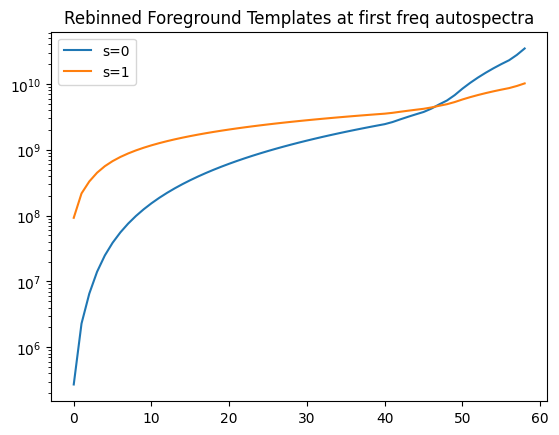

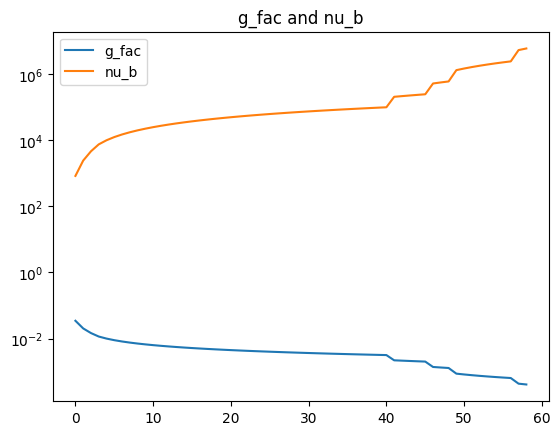

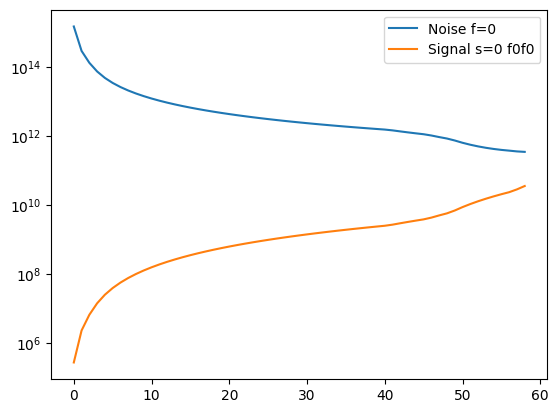

In [68]:

#quick rebin matching primecam_simulator
C_b = {}
N_b = {}

for s in range(n_fore):
    C_b[s] = {}
    for f1 in range(n_freq):
        N_b[f1] = (N_l[f1]*dl)[np.array(ell_bin-1.5,'int')].copy()
        for f2 in range(n_freq):
            C_b[s][f1,f2] = C_l[s][f1,f2][np.array(ell_bin-1.5,'int')].copy()

#59 bins
n_bins = N_b[0].shape[0]
print(n_bins)

#quick nu_b from g_fac
#nu_b = 1/(g_fac[np.array(ell_bin-1.5,'int')].copy())**2
nu_b = 1/g_fac**2

for s in range(n_fore):
    plt.plot(C_b[s][(0,0)], label=f"s={s}")
plt.legend()
plt.yscale('log')
plt.title("Rebinned Foreground Templates at first freq autospectra")
plt.show()

plt.plot(g_fac, label="g_fac")
plt.plot(nu_b,  label="nu_b")
plt.yscale('log')
plt.title("g_fac and nu_b")
plt.legend()
plt.show()

plt.plot(N_b[0], label='Noise f=0')
plt.plot(C_b[0][0,0], label='Signal s=0 f0f0')
plt.legend()
plt.yscale('log')
plt.show()

15


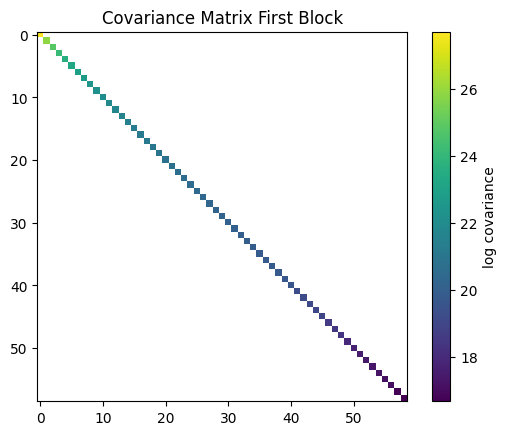

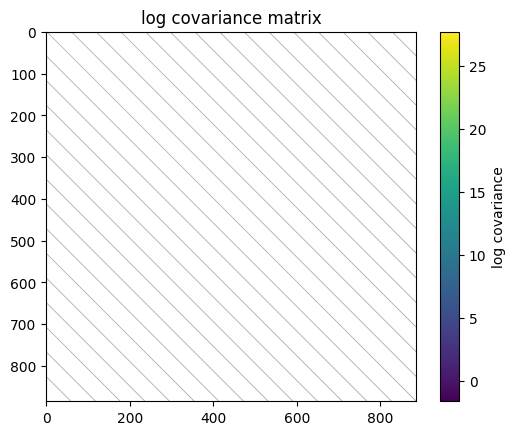

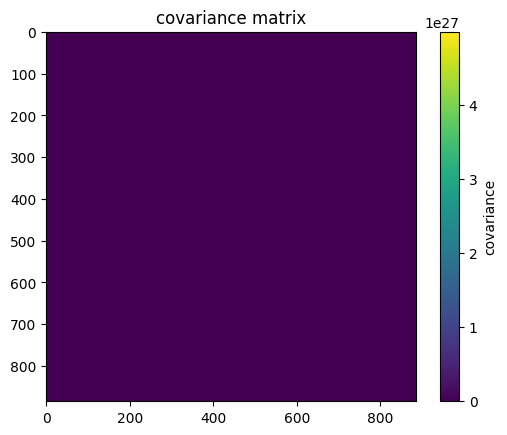

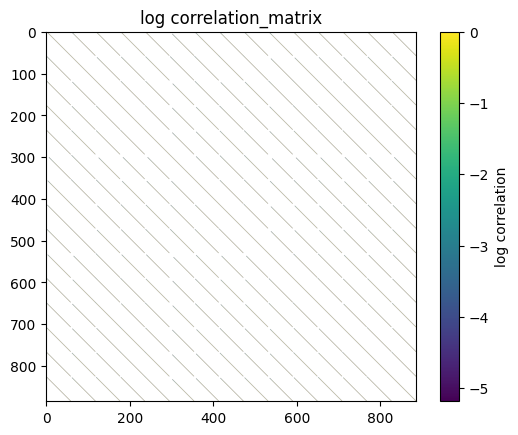

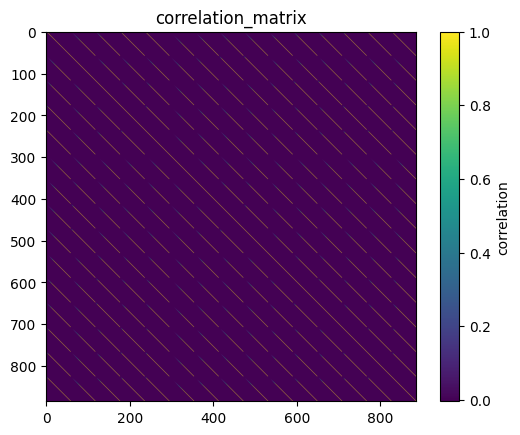

In [63]:
'''#steve code
for a in range(num_maps):
    for b in range(num_maps):
        for c in range(num_maps):
            for d in range(num_maps):
                spec1 = spectra_dict[(a, b)]
                spec2 = spectra_dict[(c, d)]
                c_ac = bin_spectra(cross_spectra[(a, c)], bin_edges)
                c_bd = bin_spectra(cross_spectra[(b, d)], bin_edges)
                c_ad = bin_spectra(cross_spectra[(a, d)], bin_edges)
                c_bc = bin_spectra(cross_spectra[(b, c)], bin_edges)
                for bin in range(num_bins):
                    cov_matrix[bin, spec1, spec2] = (1 / nu_b[bin]) * (c_ac[bin]*c_bd[bin] + c_ad[bin]*c_bc[bin])
                cov_matrix[:, spec2, spec1] = cov_matrix[:, spec1, spec2]
'''

freq_pairs = []
pair_index = {}
k = 0
for f1 in range(n_freq):
    for f2 in range(f1, n_freq):
        freq_pairs.append((f1, f2))
        pair_index[(f1, f2)] = k
        pair_index[(f2, f1)] = k
        k += 1
n_pairs = len(freq_pairs)
print(n_pairs)

#######################################################################################

def sig_noise(f1, f2):
    C_total = sum(C_b[s][f1, f2] for s in C_b) # sum C_b
    if f1 == f2: #only if this term has an auto spectra include noise
        C_total += N_b[f1]
    return C_total

######################################################################################
#closest to steve method, returns correct-looking covmat
cov_matrix = np.zeros((n_bins, n_pairs, n_pairs))
for a in range(n_freq):
    for b in range(n_freq):
        for c in range(n_freq):
            for d in range(n_freq):
                i = pair_index[(a, b)]
                j = pair_index[(c, d)]
                c_ac = sig_noise(a, c)
                c_bd = sig_noise(b, d)
                c_ad = sig_noise(a, d)
                c_bc = sig_noise(b, c)
                for bin in range(n_bins):
                    cov_matrix[bin, i, j] = (1 / nu_b[bin]) * (c_ac[bin]*c_bd[bin] + c_ad[bin]*c_bc[bin])
                cov_matrix[:, j, i] = cov_matrix[:, i, j]

#form cov_matrix[bin, fpair_1, fpair_2]
block = [[np.zeros((n_bins, n_bins)) for j in range(n_pairs)] for i in range(n_pairs)]

# Fill only the diagonal of each (n_bins × n_bins) block from cov_matrix
for i in range(n_pairs):
    for j in range(n_pairs):
        for b in range(n_bins):
            block[i][j][b, b] = cov_matrix[b, i, j]
  
blockshow = block[0][0]
plt.imshow(np.log10(blockshow), cmap='viridis')#, vmin=vmin, vmax=vmax)
plt.colorbar(label='log covariance')
plt.title("Covariance Matrix First Block")
plt.show()

#arrange blocks into full matrix
cov_total_full = np.zeros((n_bins * n_pairs, n_bins * n_pairs))
for i in range(n_pairs):
    for j in range(n_pairs):
        #location in full matrix
        row_start = i * n_bins
        row_end = (i + 1) * n_bins
        col_start = j * n_bins
        col_end = (j + 1) * n_bins

        cov_total_full[row_start:row_end, col_start:col_end] = block[i][j]


'''#chatgpt's favorite method
cov_total_full = np.zeros((n_bins * n_pairs, n_bins * n_pairs))
for b1 in range(n_bins):
    for b2 in range(n_bins):
        for p1, (f1, f2) in enumerate(freq_pairs):
            for p2, (f3, f4) in enumerate(freq_pairs):
                
                # Get total signal+noise terms at each bin
                C_ac = sig_noise(f1, f3)[b1]
                C_bd = sig_noise(f2, f4)[b2]
                C_ad = sig_noise(f1, f4)[b2]
                C_bc = sig_noise(f2, f3)[b1]

                val = (C_ac * C_bd + C_ad * C_bc) / nu_b[b1]

                # Compute full matrix indices
                idx1 = p1 * n_bins + b1
                idx2 = p2 * n_bins + b2

                cov_total_full[idx1, idx2] = val
                cov_total_full[idx2, idx1] = val  # enforce symmetry

#chatgpt other method that works with MCMC and gives a_x = 1, not sure why 
cov_total_full = np.zeros((n_bins * n_pairs, n_bins * n_pairs))
cov_per_bin = []
for b in range(n_bins):
    cov_b = np.zeros((n_pairs, n_pairs))
    for i, (f1, f2) in enumerate(freq_pairs):
        for j, (f3, f4) in enumerate(freq_pairs):
            # signal covariance sum over components s
            cov_signal = 0
            for s in range(7):
                C_f1f3 = C_b[s][f1, f3][b]
                C_f2f4 = C_b[s][f2, f4][b]
                C_f1f4 = C_b[s][f1, f4][b]
                C_f2f3 = C_b[s][f2, f3][b]
                cov_signal += (C_f1f3 * C_f2f4 + C_f1f4 * C_f2f3)

            # noise covariance - only if pairs match and frequency indices equal
            cov_noise = 0
            if (f1 == f3) and (f2 == f4):
                # noise only on autospectra (f1 == f2)
                if f1 == f2:
                    cov_noise += N_b[f1][b]**2
                # cross spectrum noise zero

            cov_b[i, j] = (cov_signal + cov_noise) / nu_b[b]

    cov_per_bin.append(cov_b)

import scipy
cov_total_full = scipy.linalg.block_diag(*cov_per_bin)
'''
#####################################################################
plt.imshow(np.log10(cov_total_full), cmap='viridis')#, vmin=vmin, vmax=vmax)
plt.colorbar(label='log covariance')
plt.title("log covariance matrix")
plt.show()
plt.imshow((cov_total_full), cmap='viridis')#, vmin=vmin, vmax=vmax)
plt.colorbar(label='covariance')
plt.title("covariance matrix")
plt.show()

def cov2corr(cov):
    stddev = np.sqrt(np.diag(cov))
    corr = cov / np.outer(stddev, stddev)
    np.fill_diagonal(corr, 1.0)
    return corr

corr_matrix = np.corrcoef(cov_total_full)
plt.imshow(np.log10(corr_matrix), cmap='viridis')#, vmin=vmin, vmax=vmax)
plt.colorbar(label='log correlation')
plt.title("log correlation_matrix")
plt.show()
plt.imshow((corr_matrix), cmap='viridis')#, vmin=vmin, vmax=vmax)
plt.colorbar(label='correlation')
plt.title("correlation_matrix")
plt.show()



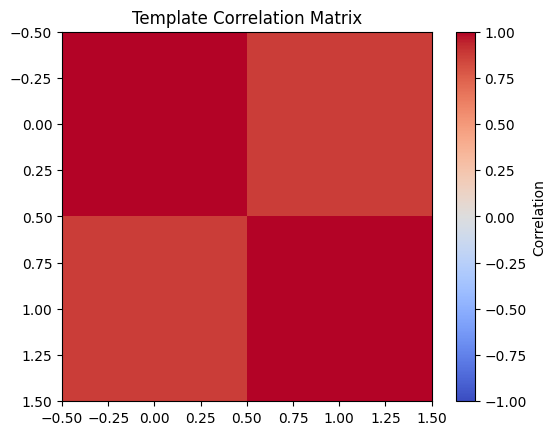

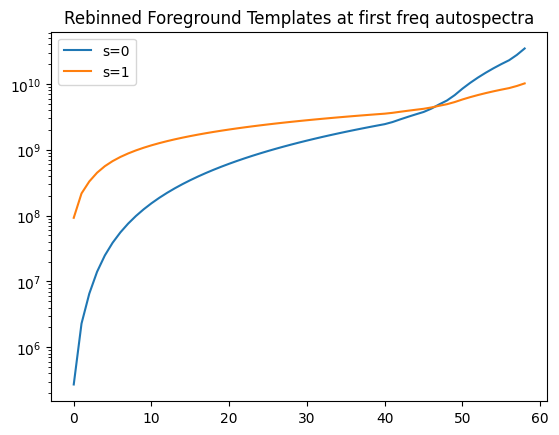

In [64]:

T_templates = {}

for s in range(n_fore):
    #make a template for each foreground spectrum
    T = np.zeros((n_bins, n_pairs))
    for idx, (f1, f2) in enumerate(freq_pairs):  # spectrum index matches mock_data index
        T[:, idx] = C_b[s][f1, f2].copy()
    T_templates[s] = T.flatten()  # now T_templates[s].shape == (n_bins * n_fore,)

template_matrix = np.array([T_templates[s] for s in range(n_fore)])
#show correlation between C_b templates
t_correlation_matrix = np.corrcoef(template_matrix)
plt.imshow(t_correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.title("Template Correlation Matrix")
plt.show()

#sanity check, replot C_b
for s in range(n_fore):
    plt.plot(C_b[s][(0,0)], label=f"s={s}")
plt.legend()
plt.yscale('log')
plt.title("Rebinned Foreground Templates at first freq autospectra")
plt.show()


In [65]:

a_true_full = {
    0: 1.0,  # a_kSZ
    1: 1.0,  # a_p
    2: 1.0,  # tSZxCIB
    3: 1.0,  # a_s
    4: 1.0,  # a_g
    5: 1.0,  # a_tSZ
    6: 1.0,  # a_c
}

#trim to just desired foregrounds
a_true = [a_true_full[i] for i in fore_indices]

# (n_bins, n_fore) array for the full signal model
signal_model = np.zeros((n_bins, n_pairs))

for s in range(n_fore):  # loop over foregrounds
    for i, (f1, f2) in enumerate(freq_pairs):
        signal_model[:, i] += a_true[s] * C_b[s][f1, f2]

model_vec = signal_model.flatten()  # shape: (n_bins * n_fore,)

mock_data = np.random.multivariate_normal(mean=model_vec, cov=cov_total_full)

cov_inv = np.linalg.inv(cov_total_full)
sign, logdet = np.linalg.slogdet(cov_total_full)


def log_likelihood(theta, T_templates, data, cov_inv, logdet):
    model = sum(a_s * T_templates[s] for s, a_s in enumerate(theta))
    delta = data - model
    return -0.5 * (delta @ cov_inv @ delta + logdet)

def log_prior(theta):
    # flat prior
    if np.all((0.0 < theta) & (theta < 2.0)):
        return 0.0
    return -np.inf

def log_probability(theta, T_templates, data, cov_inv, logdet):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, T_templates, data, cov_inv, logdet)

ndim = n_fore
nwalkers = 64
initial = np.array([1.0]*ndim) + 0.01 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability,
    args=(T_templates, mock_data, cov_inv, logdet)
)
sampler.run_mcmc(initial, 10000, progress=True)

samples = sampler.get_chain(discard=1000, thin=10, flat=True)


100%|██████████| 10000/10000 [10:32<00:00, 15.80it/s]


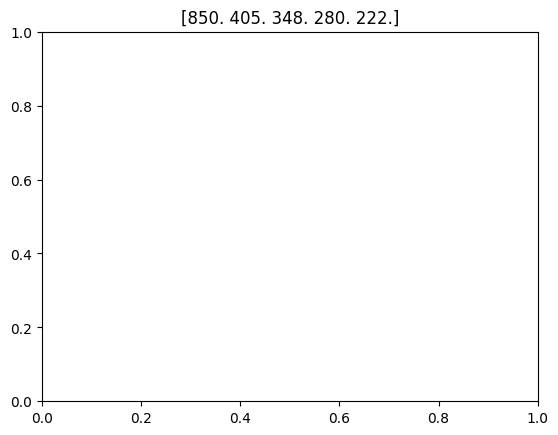

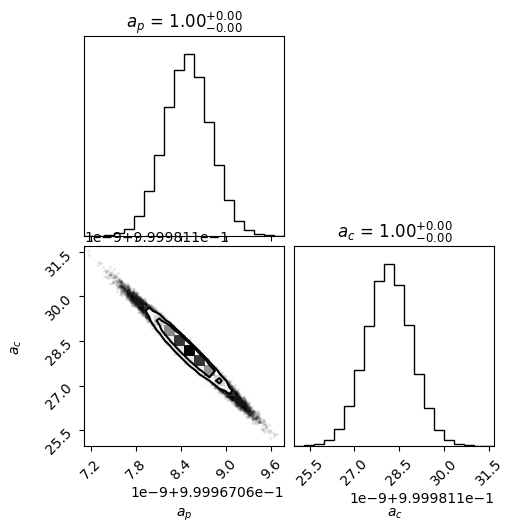

$a_p$: 1.000 ± 0.000
$a_c$: 1.000 ± 0.000


In [70]:
import corner
import matplotlib.pyplot as plt

labels_full = [
    r"$a_{\mathrm{kSZ}}$", 
    r"$a_p$", 
    r"$a_{\mathrm{tSZ}\times\mathrm{CIB}}$", 
    r"$a_s$", 
    r"$a_g$", 
    r"$a_{\mathrm{tSZ}}$", 
    r"$a_c$"
]

labels = [labels_full[i] for i in fore_indices]


fig = corner.corner(samples, labels=labels, truths=a_true, show_titles=True)
plt.show()


for i, label in enumerate(labels):
    mean = np.mean(samples[:, i])
    std = np.std(samples[:, i])
    print(f"{label}: {mean:.3f} ± {std:.3f}")